In [1]:
from typing import List, Annotated
from langgraph.graph import StateGraph, MessagesState, add_messages, START, END
from langchain_core.messages import (
    HumanMessage, 
    AIMessage, 
    SystemMessage,
    AnyMessage,
    RemoveMessage,
    trim_messages
)
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

**Single Node Workflow**

In [2]:
import os
llm = ChatOpenAI(
  api_key=os.getenv("OPENROUTER_API_KEY"),
  base_url=os.getenv("OPENROUTER_BASE_URL"),
  model="openai/gpt-oss-20b:free",
  default_headers={
    # "HTTP-Referer": getenv("YOUR_SITE_URL"),
    # "X-Title": getenv("YOUR_SITE_NAME"),
  }
)

In [ ]:
# from dotenv import load_dotenv
# load_dotenv()
# llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0.0,
# )

In [3]:
def llm_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

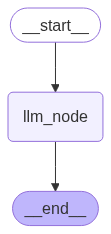

In [4]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_node", llm_node)
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

**Useful Messages List**

In [5]:
messages = [
    SystemMessage(
        content="You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.",
        name="System",
        id="0",
    ),
    HumanMessage(
        content="What is Pokemon?",
        name="User",
        id="1"
    ),
    AIMessage(
        content="I'm here to provide information specifically about FinTech. If you have " 
                "any questions related to financial technology, such as digital payments, " 
                "blockchain, cryptocurrencies, or financial services innovations, feel free " 
                "to ask!",
        name="FintechAssistant",
        id="2",
    ),
    HumanMessage(
        content="What is BlockChain?",
        name="User",
        id="3"
    ),
    AIMessage(
        content="Blockchain is a decentralized digital ledger technology that records" 
                "transactions across multiple computers in a way that ensures the security, " 
                "transparency, and integrity of the data. Each transaction is grouped into " 
                "a block, and these blocks are linked together in chronological order to form " 
                "a chain, hence the name blockchain.",
        name="FintechAssistant",
        id="4",
    ),
    HumanMessage(
        content="What is a credit card fraud?",
        name="User",
        id="5"
    ),
]

**Filter Messages during Invocation**

In [6]:
complete_output = graph.invoke({"messages": messages})

In [7]:
complete_output["messages"][-1].pretty_print()

================================== Ai Message ==================================

**Credit card fraud** is the unauthorized use of a credit card or its information to obtain goods, services, or cash. It typically involves stealing card numbers, cloning cards, or hacking transaction data, leading to financial loss for cardholders and merchants.


In [8]:
complete_output["messages"][-1].response_metadata["token_usage"]

{'completion_tokens': 119,
 'prompt_tokens': 225,
 'total_tokens': 344,
 'completion_tokens_details': None,
 'prompt_tokens_details': None}

In [9]:
filtered_output = graph.invoke({"messages": [messages[0], messages[-1]]})

In [10]:
filtered_output["messages"][-1].pretty_print()

================================== Ai Message ==================================

**Credit‑card fraud** is the unauthorized use of someone else’s credit‑card data to obtain goods, services, or cash. It typically involves:

1. **Data theft** – obtaining card numbers, expiration dates, CVV codes, or PINs (e.g., via skimming, phishing, malware).  
2. **Impersonation** – using that data to make purchases or withdraw funds either online, over the phone, or at a point‑of‑sale terminal.  
3. **Transaction manipulation** – altering or creating false transactions in a merchant or card‑network system.  

Fraud damages the cardholder, the issuer, and merchants, and it fuels broader financial crime.


In [12]:
filtered_output["messages"][-1].response_metadata["token_usage"]

{'completion_tokens': 177,
 'prompt_tokens': 103,
 'total_tokens': 280,
 'completion_tokens_details': None,
 'prompt_tokens_details': None}

**Filter Messages inside a node**

In [13]:
class State(MessagesState):
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [14]:
def llm_node(state: State):
    filtered_messages = state["messages"][-3:]
    ai_message = llm.invoke(filtered_messages)
    filtered_messages.append(ai_message)
    return {"messages": ai_message, "filtered_messages": filtered_messages}

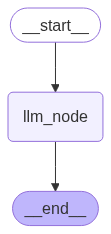

In [15]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [16]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the securi

In [17]:
output = graph.invoke({'messages': messages})
for m in output['filtered_messages']:
    m.pretty_print()

================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

**Credit‑card fraud** is the illegal use of a payment‑card (the physical plastic card or its digital token) in order to obtain goods, services, or money without the legitimate cardholder’s permission. It is one of the most common forms of financial

**Remove Messages**

In [18]:
messages[:-3]

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.", additional_kwargs={}, response_metadata={}, name='System', id='0'),
 HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, name='User', id='1'),
 AIMessage(content="I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!", additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='2')]

In [19]:
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-3]]
add_messages(messages, delete_messages)

[HumanMessage(content='What is BlockChain?', additional_kwargs={}, response_metadata={}, name='User', id='3'),
 AIMessage(content='Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.', additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='4'),
 HumanMessage(content='What is a credit card fraud?', additional_kwargs={}, response_metadata={}, name='User', id='5')]

In [20]:
class State(MessagesState):
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [21]:
def removal_filter(state: State):
    filtered_messages = [
        RemoveMessage(id=m.id) 
            for m in state["messages"][:-3] 
            if m.name != "System"
    ]
    return {
        "filtered_messages": add_messages(
            state["messages"], 
            filtered_messages
        )
    }

In [22]:
def llm_node(state: State):
    ai_message = llm.invoke(state["filtered_messages"])
    return {
        "filtered_messages": ai_message,
    }

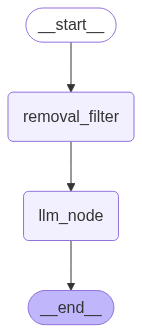

In [23]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_node("removal_filter", removal_filter)
workflow.add_edge(START, "removal_filter")
workflow.add_edge("removal_filter", "llm_node")
workflow.add_edge("llm_node", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [24]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the securi

In [25]:
output = graph.invoke({'messages': messages})
for m in output['filtered_messages']:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is the unauthorized use of a c

**Trim Messages**

In [26]:
trim_messages(
    messages,
    max_tokens=30,
    strategy="last",
    token_counter=llm,
    allow_partial=False,
    include_system=True
)

NotImplementedError: get_num_tokens_from_messages() is not presently implemented for model openai/gpt-oss-20b:free. See https://platform.openai.com/docs/guides/text-generation/managing-tokens for information on how messages are converted to tokens.

In [27]:
class State(MessagesState):
    max_tokens: int
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [ ]:
def trim_filter(state: State):
    max_tokens = state["max_tokens"]
    messages = state["messages"]
    filtered_messages = messages
    if max_tokens:
        filtered_messages = trim_messages(
            messages=messages,
            max_tokens=max_tokens,
            strategy="last",
            token_counter=llm,
            include_system=True,
            allow_partial=False
        )
    return {"filtered_messages": filtered_messages}

In [ ]:
def llm_node(state: State):
    return {"filtered_messages": llm.invoke(state["filtered_messages"])}

In [ ]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_node("trim_filter", trim_filter)
workflow.add_edge(START, "trim_filter")
workflow.add_edge("trim_filter", "llm_node")
workflow.add_edge("llm_node", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
for m in messages:
    m.pretty_print()

In [ ]:
output = graph.invoke(
    input={
        "max_tokens": 50,
        "messages": messages
    }
)

In [ ]:
for m in output['filtered_messages']:
    m.pretty_print()

**Summary**

In [ ]:
messages[1:-1]

In [ ]:
messages_to_summarize = messages[1:-1]
summary_message = HumanMessage(
    content="Create a summary of the conversation above:", 
    name="User"
)
ai_message = llm.invoke(
    add_messages(
        messages_to_summarize,
        summary_message
    )
)

In [ ]:
ai_message.content

In [ ]:
ai_message.id = "1"
messages[-1].id = "2"

In [ ]:
remaining_messages = [messages[0]] + [ai_message] + [messages[-1]]

In [ ]:
remaining_messages

In [ ]:
remaining_messages.append(llm.invoke(remaining_messages))

In [ ]:
for m in remaining_messages:
    m.pretty_print()

In [ ]:
remaining_messages[-1].response_metadata["token_usage"]